In [1]:
from parcels import (
    AdvectionRK4_3D,
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    plotTrajectoriesFile
)

from operator import attrgetter
from datetime import datetime, timedelta

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os

fatal: not a git repository (or any of the parent directories): .git


In [15]:
# Parameters

##### release position 
release_zone = "test_1500"
bathymodiolus_delta_lat = 0.6 #seamount diameter

release_depth = 1500

# release particles
number_particles = 100000

# release timing
release_time_in_days = 1   # e.g. from 01/01/2009 to 03/01/2009 
start_year = 2009
#start_month = 3
#start_day = 1

# experiment duration etc
runtime_in_days = 42
dt_in_minutes = 10

# particle positions are stored every x hours 
outputdt_in_hours = 24

# release location file
release_locations_file = "/gxfs_work/geomar/smomw523/master-thesis/data/config/test_stations.csv"

# location of input data
data_path = '/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/'
experiment_name = 'INALT20.L46-KFS104' 
data_resolution = '1d'

# location of mask data
mask_path = '/gxfs_work/geomar/smomw523/master-thesis/data/config/INALT/104/'
mesh_mask_filename = '1_mesh_mask_iMirabilis.nc'
topo_path = '/gxfs_work/geomar/smomw523/master-thesis/data/config/INALT/topography_KFS104.nc'

# names of files to load
fname_U = f'1_{experiment_name}_{data_resolution}_20??*_grid_U_iMirabilis.nc'  
fname_V = f'1_{experiment_name}_{data_resolution}_20??*_grid_V_iMirabilis.nc'
fname_T = f'1_{experiment_name}_{data_resolution}_20??*_grid_T_iMirabilis.nc'
fname_W = f'1_{experiment_name}_{data_resolution}_20??*_grid_W_iMirabilis.nc'

# location of output data
outpath = f'/gxfs_work/geomar/smomw523/master-thesis/output_data/{experiment_name}/'
output_filename = 'Tides10-Column_{release_zone}_{start_year}{start_month:02d}{start_day:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-{RNG_seed}.nc'

# how to initialize the random number generator
RNG_seed = 12345


In [16]:
# remove spaces and lower the input from csv file
release_zone = release_zone.lower().replace(' ', '-').replace("'", '-')

# correct runtime
corrected_runtime_in_days = runtime_in_days + release_time_in_days

### Construct input / output paths etc.

In [19]:
data_path = Path(data_path)
mask_path = Path(mask_path)
topo_path = Path(topo_path)
outpath = Path(outpath)
mesh_mask = mask_path / mesh_mask_filename
output_filename = output_filename.format(
    release_zone = release_zone,
    RNG_seed=RNG_seed,
    start_year=start_year,
    start_month = start_month,
    start_day = start_day,
    runtime_in_days = runtime_in_days,
    number_particles=number_particles
)
outfile = outpath / output_filename

In [20]:
ds_mesh_mask = xr.open_dataset(mesh_mask)
display(ds_mesh_mask)

<xarray.Dataset>
Dimensions:       (t: 1, y: 409, x: 662, z: 46)
Dimensions without coordinates: t, y, x, z
Data variables: (12/44)
    e1f           (t, y, x) float64 ...
    e1t           (t, y, x) float64 ...
    e1u           (t, y, x) float64 ...
    e1v           (t, y, x) float64 ...
    e2f           (t, y, x) float64 ...
    e2t           (t, y, x) float64 ...
    ...            ...
    tmask         (t, z, y, x) int8 ...
    tmaskutil     (t, y, x) int8 ...
    umask         (t, z, y, x) int8 ...
    umaskutil     (t, y, x) int8 ...
    vmask         (t, z, y, x) int8 ...
    vmaskutil     (t, y, x) int8 ...
Attributes:
    history:  Thu Jan 23 17:08:58 2020: ncks -F -d x,1390,2051 -d y,857,1265 ...
    NCO:      4.6.8

### Load release location

In [21]:
def load_release_locations(release_locations_file):
    df = pd.read_csv(release_locations_file, delimiter=",")
    df = df.set_index("release_zone")
    df.index = df.index.str.lower().str.replace(' ', '-').str.replace("'", '-')
    return df

In [22]:
release_locations = load_release_locations(release_locations_file)
bathymodiolus_lat, bathymodiolus_lon, release_depth = release_locations.loc[release_zone]
bathymodiolus_delta_lon = bathymodiolus_delta_lat * np.cos(np.deg2rad(bathymodiolus_lat))

In [23]:
def fieldset_defintions(
    list_of_filenames_U, list_of_filenames_V,
    list_of_filenames_W, list_of_filenames_T,
    mesh_mask
):
    
    filenames = {'U': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_U},
                 'V': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_V},
                 'W': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_W},
                 'T': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_T[0],
                       'data': list_of_filenames_T},
                 'topo': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'data': (topo_path)}
                }

    variables = {'U': 'vozocrtx',
                 'V': 'vomecrty',
                 'W': 'vovecrtz',
                 'T': 'votemper',
                 'topo': 'topography',
                }
                 
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                       'time': 'time_counter'}, 
                  'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  
                  'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  
                  'T': {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht',
                        'time': 'time_counter'},
                  'topo': {'lon': 'glamt', 'lat': 'gphit'}, 
                 }  # U,V,W auf f-nodes !  T auf t-nodes

    return FieldSet.from_nemo(
        filenames, variables, dimensions,
        chunksize=False,
        mesh='spherical',
        tracer_interp_method='nearest', #because of topography
        allow_time_extrapolation=True
    )

In [24]:
def create_fieldset(
    data_path=data_path, experiment_name=experiment_name,
    fname_U=fname_U, fname_V=fname_V, fname_W=fname_W, fname_T=fname_T,
    mesh_mask = mesh_mask
):
    
    files_U = list(sorted((data_path / experiment_name).glob(fname_U)))
    files_V = list(sorted((data_path / experiment_name).glob(fname_V)))
    files_W = list(sorted((data_path / experiment_name).glob(fname_W)))
    files_T = list(sorted((data_path / experiment_name).glob(fname_T)))
    
    fieldset = fieldset_defintions(
        files_U, files_V,
        files_W, files_T, mesh_mask)
    return fieldset

In [25]:
list(sorted((data_path / experiment_name).glob(fname_U)))

[PosixPath('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS104/1_INALT20.L46-KFS104_1d_20080101_20081231_grid_U_iMirabilis.nc'),
 PosixPath('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS104/1_INALT20.L46-KFS104_1d_20090101_20091231_grid_U_iMirabilis.nc'),
 PosixPath('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS104/1_INALT20.L46-KFS104_1d_20100101_20101231_grid_U_iMirabilis.nc'),
 PosixPath('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS104/1_INALT20.L46-KFS104_1d_20120101_20121231_grid_U_iMirabilis.nc')]

In [26]:
fieldset = create_fieldset()

/opt/conda/lib/python3.10/site-packages/parcels/field.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  timeslices = np.array(timeslices)
/opt/conda/lib/python3.10/site-packages/parcels/field.py:250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataFiles = np.concatenate(np.array(dataFiles))
/opt/conda/lib/python3.10/site-packages/parcels/field.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant t

### Create a set of particles with random initial positions

In [27]:
np.random.seed(RNG_seed)

time = np.sort(
        datetime(start_year, start_month, start_day)
        + timedelta(hours=1) * np.random.randint(
            0, (release_time_in_days) * 24 * 60 / dt_in_minutes, size=(number_particles, )
        )
)

In [28]:
def get_uniform_random_in_cube(
    lat_start=bathymodiolus_lat-bathymodiolus_delta_lat, lat_end=bathymodiolus_lat+bathymodiolus_delta_lat,
    lon_start=bathymodiolus_lon-bathymodiolus_delta_lon, lon_end=bathymodiolus_lon+bathymodiolus_delta_lon,
    release_depth=release_depth,
    N=10,
):
    lat = np.rad2deg(
        np.arcsin(
            np.random.uniform(
                np.sin(np.deg2rad(lat_start)), 
                np.sin(np.deg2rad(-22.9)),      # eigentlich lat_end statt -22.9
                size=(N, ),
            )
        )
    )
    lon = np.random.uniform(lon_start, lon_end, size=(N, )) 
    depth = np.random.uniform(0,release_depth, size=(N, ))
    
    return pd.DataFrame(
        {
            "lat": lat,
            "lon": lon,
            "depth": depth,
        }
    )

In [29]:
mask_path

PosixPath('/gxfs_work/geomar/smomw523/master-thesis/data/config/INALT/104')

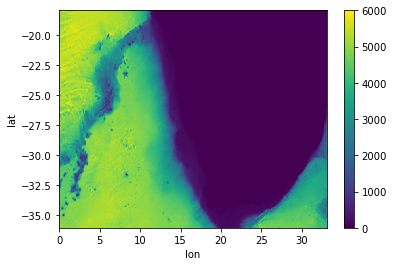

In [35]:
INALT_mask = xr.open_dataset(mask_path/mesh_mask_filename)
topo_INALT = np.sum((INALT_mask.tmask*INALT_mask.e3t_0).isel(t=0),axis=0)
topo_INALT.rename({'lat','lon'})
topo_INALT = topo_INALT.assign_coords({"lon": INALT_mask.glamt.isel(t=0,y=0)})
topo_INALT = topo_INALT.assign_coords({"lat": INALT_mask.gphit.isel(t=0,x=0)})
topo_INALT = topo_INALT.swap_dims({'x': 'lon'})
topo_INALT = topo_INALT.swap_dims({'y': 'lat'})

topo_INALT.plot();

In [36]:
release_points = get_uniform_random_in_cube(N=200*number_particles,
)
release_points["topo_INALT"] = topo_INALT.sel(
    lat=release_points.to_xarray().lat,
    lon=release_points.to_xarray().lon,
    method="nearest",
)
release_points = release_points.where((release_points.topo_INALT > release_points.depth+10) & ( # at least 10 meters above ground
    release_points.topo_INALT < release_depth) & (release_points.topo_INALT < 1500)).dropna().iloc[
    :number_particles].reset_index(drop=True)

In [37]:
release_points

,lat,lon,depth,topo_INALT
0,-23.138754,8.249525,404.104491,1016.451951
1,-23.228668,8.367384,659.271635,1461.537148
2,-23.295674,8.284434,1202.570002,1292.498505
3,-23.198611,8.272705,966.002315,1005.950979
4,-23.249514,8.239737,602.413774,1037.453896
...,...,...,...,...
99995,-23.128015,8.220683,440.211794,1267.493103
99996,-23.286406,8.324468,13.390520,1292.498505
99997,-23.183321,8.245224,182.723950,1005.950979
99998,-23.254573,8.177099,1043.804798,1377.516873


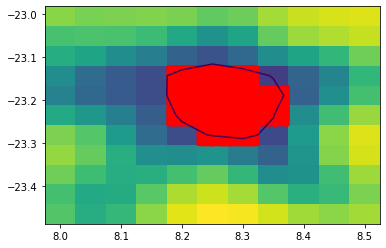

In [38]:
plt.pcolormesh(topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)))
cl_INALT=plt.contour(topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)),levels=[1500])
plt.scatter(release_points.lon,release_points.lat,s=0.1,color='red')

In [39]:
time[0:3]

array([datetime.datetime(2009, 3, 1, 0, 0),
       datetime.datetime(2009, 3, 1, 0, 0),
       datetime.datetime(2009, 3, 1, 0, 0)], dtype=object)

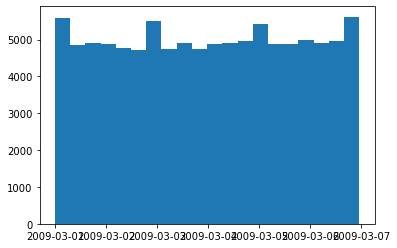

In [40]:
plt.hist(time, bins=20);

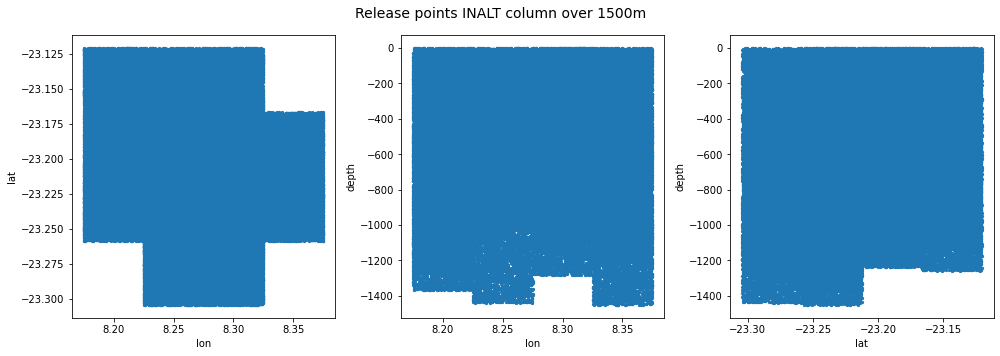

In [41]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.scatter(release_points.lon, release_points.lat, s=5)
plt.xlabel('lon')
plt.ylabel('lat')
plt.subplot(1,3,2)
plt.scatter(release_points.lon, -release_points.depth, s=5)
plt.xlabel('lon')
plt.ylabel('depth')
plt.subplot(1,3,3)
plt.scatter(release_points.lat, -release_points.depth, s=5)
plt.xlabel('lat')
plt.ylabel('depth')

fig.suptitle('Release points INALT column over 1500m',fontsize = 14)
fig.tight_layout()

#plt.savefig(('../output_data/{experiment_name}/plots/release-points_column_{release_zone}_{start_year}{start_month:02d}{start_day:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-{RNG_seed}.png').format(
#    experiment_name = experiment_name,
#    release_zone = release_zone,
#    RNG_seed=RNG_seed,
#    start_year=start_year,
#    start_month = start_month,
#    start_day = start_day,
#    runtime_in_days = runtime_in_days,
#    number_particles=number_particles)
#           )

plt.show;

In [42]:
class SampleParticle(JITParticle):  # Define a new particle class
    topography = Variable(
        "topography", initial=fieldset.topo
    )  # Variable 'topography' initialised by sampling the topography
    
class SampleParticleInitZero(JITParticle):
    """Define a new particle class with Variable 'topography' init 0"""

    topography = Variable("topography", initial=0)
    depthdiff = Variable("depthdiff", initial=0)
    
    distance = Variable('distance', initial=0., dtype=np.float32)  # the distance travelled
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.

In [43]:
%%time
pset = ParticleSet(
    fieldset=fieldset,
    pclass=SampleParticleInitZero, #JITparticle
    lat=release_points.lat,
    lon=release_points.lon,
    depth=release_points.depth,
    time=time
)

CPU times: user 322 ms, sys: 3.02 ms, total: 325 ms
Wall time: 325 ms


In [44]:
kernel = pset.Kernel(AdvectionRK4_3D)

In [45]:
def SampleT(particle, fieldset, time):  
    particle.topography = fieldset.topo[time, particle.depth, particle.lat, particle.lon]
    particle.depthdiff = fieldset.topo[time, particle.depth, particle.lat, particle.lon] - particle.depth

sample_kernel = pset.Kernel(SampleT)  # Casting the SampleT function to a kernel.

In [46]:
pset.execute(sample_kernel, dt=0)

output_file = pset.ParticleFile(name=f"INALT-InitZero_{start_year}{start_month:02d}{start_day:02d}.zarr", outputdt=timedelta(minutes=dt_in_minutes))

INFO: Compiled ArraySampleParticleInitZeroSampleT ==> /tmp/parcels-726810/lib220b51bbdbdb2221d07647f44937d12d_0.so


In [47]:
def TotalDistance(particle, fieldset, time):
    
    # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    particle.prev_lon = particle.lon  # Set the stored values for next iteration.
    particle.prev_lat = particle.lat

In [48]:
output_nc_dist = f"INALTtides-CurrentParticlesDist-{start_year}{start_month:02d}{start_day:02d}.nc"
try:
    os.remove(output_nc_dist)
except OSError:
    pass

file_dist = pset.ParticleFile(name=output_nc_dist, 
                                outputdt=timedelta(hours=1))

k_dist = pset.Kernel(TotalDistance)  # Casting the TotalDistance function to a kernel.

### Be able to handle errors during integration

In [49]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
recovery_cases = {ErrorCode.ErrorOutOfBounds: DeleteParticle,
    ErrorCode.ErrorThroughSurface: DeleteParticle
    }

In [50]:
outfile

PosixPath('/gxfs_work/geomar/smomw523/master-thesis/output_data/INALT20.L46-KFS104/Tides10-Column_test_1500_20090301_RT-42_N-100000_seed-12345.nc')

In [51]:
output_pfile = pset.ParticleFile(name=outfile, outputdt=timedelta(hours=outputdt_in_hours))

In [52]:
pset.execute(
    kernel + sample_kernel + k_dist,
    runtime=timedelta(days=corrected_runtime_in_days),
    dt=timedelta(minutes=dt_in_minutes),
    output_file=output_pfile,
    recovery=recovery_cases,
)

INFO: Compiled ArraySampleParticleInitZeroAdvectionRK4_3DSampleTTotalDistance ==> /tmp/parcels-726810/lib53d8b8aa6213e16070c3608462228923_0.so
INFO: Temporary output files are stored in /gxfs_work/geomar/smomw523/master-thesis/output_data/INALT20.L46-KFS104/out-NRALIKWL.
INFO: You can use "parcels_convert_npydir_to_netcdf /gxfs_work/geomar/smomw523/master-thesis/output_data/INALT20.L46-KFS104/out-NRALIKWL" to convert these to a NetCDF file during the run.
100%|███████████████████████████| 3715200.0/3715200.0 [09:13<00:00, 6709.80it/s]


In [53]:
output_pfile.export()

In [54]:
particle_ds = xr.open_dataset(outfile)
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 100000, obs: 44)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
    topography  (traj, obs) float32 ...
    depthdiff   (traj, obs) float32 ...
    distance    (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

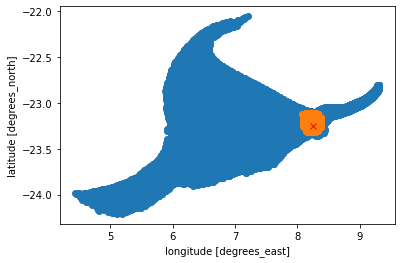

In [55]:
particle_ds.plot.scatter(x="lon", y="lat")
particle_ds.isel(obs=0).plot.scatter(x="lon", y="lat")
plt.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx')

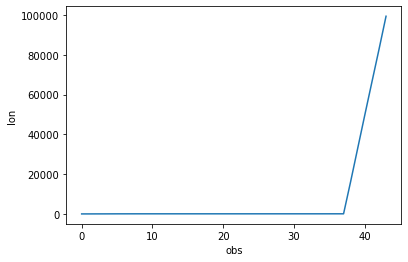

In [56]:
particle_ds.lon.isnull().sum("traj").plot()

##### 